# Analysis of tutoring center sign-in data

In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
from datetime import date
import seaborn as sns

Read in the data kept in the ..\Dropbox\sign_in_exports folder
Right now we're just manually grabbing one csv file.  But we could script this to grab the most recent file in the folder.

In [3]:
df = pd.read_csv(r'\Users\jconning\Dropbox\sign_in_exports\sign_in_export_2015-10-28.csv')
#df = pd.read_csv(r'\Users\Jonathan\Dropbox\sign_in_exports\sign_in_export_2015-10-28.csv')

Let's now create a datetime index to use datetime functions below.

In [4]:
df['timestamp'] = pd.to_datetime(df.Date + ' ' + df.Time)
df = df.set_index(pd.DatetimeIndex(df.timestamp))

In [5]:
weekmask =['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

In [6]:
df['dayofweek']= [weekmask[date.dayofweek] for date in df.index]

What are the most popular days of the week:

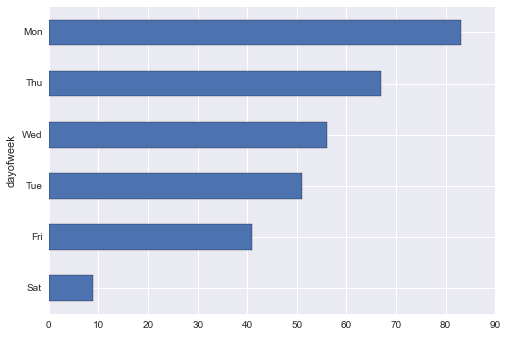

In [7]:
df.groupby('dayofweek').size().sort_values().plot(kind='barh')

# Summary statistics
The pandas groupby method generates a dictionary. For example if we group by course as below it will create a dictionary where the keys are each course 100, 200, 201 etc and for each key the row numbers where that course appears.

Once we have that dictionary we can use counts and other methods.

In [8]:
byDay = df.groupby('Date')
df_Day = byDay.size()

## Visits by date
The plot below is not quite right because we haven't told pandas to use a datetime index.

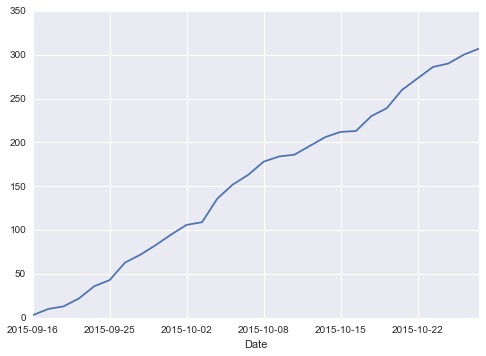

In [9]:
df_Day.cumsum().plot()

It would be nice to use the python (or pandas) datetime library methods to graph by day of the week

## By course and instructor

In [11]:
byCourse = df.groupby(['Catalog Num'])
df_Course = byCourse.size()
df_Course

Catalog Num
10000    103
20000     34
20100      5
21000      1
22100     22
26000      1
30000     54
30100      7
30500      1
32100      9
33000      2
34000     24
34500     14
35500     16
36500     10
36600      1
39556      1
73200      1
dtype: int64

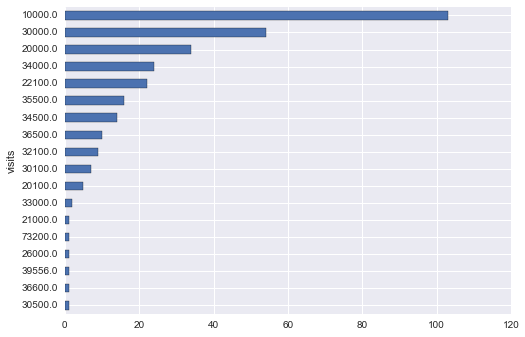

In [12]:
Courseplot = df_Course.sort_values().plot(kind='barh')
Courseplot.set_ylabel("visits")

In [13]:
byCourseProf = df.groupby(['Catalog Num','Instructor'])
df_CourseProf = byCourseProf.size().sort_values(ascending=False)
df_CourseProf

Catalog Num  Instructor  
10000        George          74
30000        Wright          52
34000        Conning         24
20000        Basu            21
35500        George          16
34500        Sevak           14
22100        Nugent          14
10000        Filer           13
             Goodspeed       11
36500        Ma               8
32100        Gharehogozli     8
20000        Deb              6
             Nugent           6
30100        Silverstein      5
22100        Demir            5
10000        Chernick         5
20100        Abreu            4
22100        Leboeuf          3
30000        Nyman            2
30100        Agbeyegbe        2
33000        Gurevich         2
36500        Lu               2
26000        Nyman            1
20100        Agbeyegbe        1
39556        Chaterjee        1
20000        Sevak            1
30500        Baker            1
32100        Leboeuf          1
36600        Carias           1
73200        Filer            1
dtype: int64

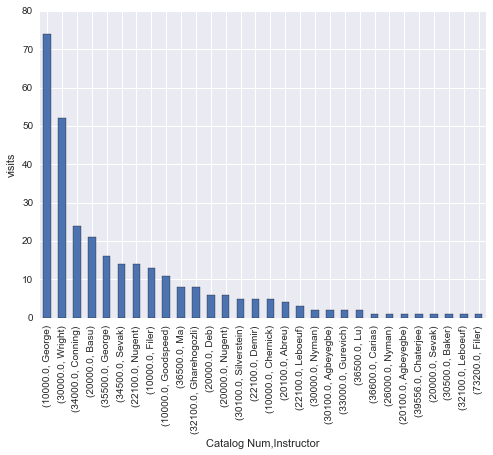

In [14]:
CourseProfplot = df_CourseProf.sort_values(ascending=False).plot(kind='bar')
CourseProfplot.set_ylabel("visits")

##  Some things we could do
   - Calendar analysis
   -  Calendar heatmap
   -  Agree on condensed summary report to send profs
       - 'this week'
       - 'semester to date'
   - more detailed report to profs
       - list of students
   - 